In [ ]:
%cd ../..

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import collections

In [3]:
from bokeh.io import output_notebook, show
import bokeh.plotting
import bokeh.layouts
output_notebook()

from bokeh.models import LinearAxis, Range1d

Loading BokehJS ...

In [38]:
import matplotlib.pyplot as plt

In [4]:
import datetime
from pytz import timezone

In [5]:
from pathlib import Path

In [6]:
import pfrl

In [7]:
from get_stock_price import StockDatabase

In [8]:
from envs_ver2 import OneStockEnv, NormalizeState, NormalizeReward

In [9]:
from visualize_trading_process_ver1 import plot_trading_process_matplotlib, plot_trading_process_bokeh

## データベース

In [10]:
db_path = Path("E:/システムトレード入門/trade_system_git_workspace/db/stock_db") / Path("stock.db")
stock_db = StockDatabase(db_path)

## 環境の作成

In [11]:
jst_timezone = timezone("Asia/Tokyo")
start_datetime = jst_timezone.localize(datetime.datetime(2020,11,1,0,0,0))
end_datetime = jst_timezone.localize(datetime.datetime(2020,12,1,0,0,0))
#end_datetime = get_next_workday_jp(start_datetime, days=11)  # 営業日で一週間(5日間)

#stock_names = "4755"
#stock_names = "9984"
stock_names = "6502"
#stock_names = ["6502","4755"]
#stock_list = ["4755","9984","6701","7203","7267"]

stock_df = stock_db.search_span(stock_names=stock_names, 
                                start_datetime=start_datetime,
                                end_datetime=end_datetime,
                                freq_str="T",
                                to_tokyo=True
                               )

use_ohlc="Close"

In [12]:
initial_cash = 3.e6  # 種銭：100万円
initial_unit = 50  # 初期単元数

freq_str = "5T"
episode_length = 12*5*7  # 1週間

#state_time_list = [0,1,12,12*3,12*5,12*5*3],  # [現在，次時刻，一時間後，3時間後，5時間後(1日後), 15時間後(3日後)]
state_time_list = [0,
                   1,
                   2,
                   6,
                   12,
                   12*2,
                   12*3,
                   12*4,
                   12*5*1,
                   12*5*2,
                   12*5*3,
                   12*5*4,
                   12*5*5,
                   ]  # 現在，5分後, 10分後, 30分後, 1時間後, 2時間後, 3時間後, 4時間後, 1日後, 2日後, 3日後, 4日後, 5日後, 6日後, 7日後

one_unit_stocks = 20
max_units_number = 5
stay_penalty_unit_bound=30
stay_penalty_cash_bound = 1.e5
penalty_mcp_np_diff_bound = 3



env = OneStockEnv(stock_db,
                  stock_names=stock_names,
                  start_datetime=start_datetime,
                  end_datetime=end_datetime,
                  freq_str="5T",
                  episode_length=episode_length,  # 一週間
                  state_time_list=state_time_list,
                  use_ohlc=use_ohlc,  # 終値を使う
                  initial_cash=initial_cash,  # 種銭：100万円,
                  initial_unit=initial_unit,
                  use_view=False,
                  one_unit_stocks=one_unit_stocks,  # 独自単元数
                  max_units_number=max_units_number,  # 一度に売買できる独自単元数
                  low_limmit=1.e4,  # 全財産がこの値以下になれば終了
                  interpolate=True,
                  stay_penalty_unit_bound=stay_penalty_unit_bound  # このunit数以下の場合のstayはペナルティ
                 )

### 前処理用のクラス 

In [13]:
state_transform = NormalizeState(cash_const=initial_cash,
                                 unit_const=100,
                                 price_const=1.e4,
                                )

reward_transform = NormalizeReward(reward_const=5.e3,
                                  )

### Q関数 

In [14]:
class QFunction(nn.Module):
    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(obs_size, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.fc2 = nn.Linear(32, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 256)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.fc4 = nn.Linear(256, n_actions)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        
        x = self.fc4(x)
        out = pfrl.action_value.DiscreteActionValue(x)
        return out

In [15]:
obs_size = env.observation_space.low.size
print("observation size:", obs_size)
n_actions = env.action_space.n
print("action size:",n_actions)
q_func = QFunction(obs_size, n_actions)

observation size: 16
action size: 11


In [16]:
optimizer = torch.optim.Adam(q_func.parameters(), eps=1e-4)

gamma = 0.95

init_episilon = 0.3
init_explorer = pfrl.explorers.ConstantEpsilonGreedy(epsilon=init_episilon,
                                                random_action_func=env.action_space.sample
                                               )

replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10**6)


def phi_func(observe):
    observe_array = observe.to_numpy()
    return observe_array.astype(np.float32, copy=False)


phi = phi_func

gpu = -1 # -1 is cpu

good_agent = pfrl.agents.DoubleDQN(
    q_function=q_func,
    optimizer=optimizer,
    replay_buffer=replay_buffer,
    gamma=gamma,
    explorer=init_explorer,
    replay_start_size=500,
    update_interval=1,
    target_update_interval=100,
    phi=phi,
    gpu=gpu
)

bad_agent = pfrl.agents.DoubleDQN(
    q_function=q_func,
    optimizer=optimizer,
    replay_buffer=replay_buffer,
    gamma=gamma,
    explorer=init_explorer,
    replay_start_size=500,
    update_interval=1,
    target_update_interval=100,
    phi=phi,
    gpu=gpu
)

### 良学習モデルのロード 

In [17]:
folder_name = "2020_12_28__11_30_41"
load_path = Path("agents") / Path(folder_name)

good_agent.load(load_path)

### 不良学習モデルのロード 

In [18]:
folder_name = "2020_12_30__20_13_19"
#load_path = Path("agents") / Path(folder_name)
load_path = Path("searched_agents") / Path(folder_name)
bad_agent.load(load_path)

### 評価のための関数 

In [19]:
def episode(env, agent, state_transform=None, reward_transform=None, print_span=None, is_observe=True):
    state_list = []
    info_list = []
    action_list = []
    
    obs,_,_,info = env.reset()

    state_list.append(obs)
    info_list.append(info)
    R = 0
    t = 1
    if print_span is not None:
        print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                             info["all_property"],
                                                                                             obs.unit_number,
                                                                                             obs.now_price,
                                                                                             info["penalty"],
                                                                                             obs.cash
                                                                                            ))
    
    if state_transform is not None:
        normalized_obs = state_transform(obs)
    else:
        normalized_obs = obs

    while True:
        action = agent.act(normalized_obs)
        action_list.append(action)
        obs, reward, done, info = env.step(action)
        R += reward
        t += 1
        reset = False


        # state, rewardの前処理
        if state_transform is not None:
            normalized_obs = state_transform(obs)
        else:
            normalized_obs = obs
        if reward_transform is not None:
            normalized_reward = reward_transform(reward)
        else:
            normalized_reward = reward

        if is_observe:  # 観測(学習)する場合
            agent.observe(normalized_obs, normalized_reward, done, reset)

        state_list.append(obs)
        info_list.append(info)

        if done or reset:
            break
        if print_span is not None:
            if t%print_span==0:
                print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                                     info["all_property"],
                                                                                                     obs.unit_number,
                                                                                                     obs.now_price,
                                                                                                     info["penalty"],
                                                                                                     obs.cash
                                                                                                    ))
                print("\taction_counter:",collections.Counter(action_list))
    
    if print_span is not None:
        print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                             info["all_property"],
                                                                                             obs.unit_number,
                                                                                             obs.now_price,
                                                                                             info["penalty"],
                                                                                             obs.cash
                                                                                            ))
        print("\taction_counter:",collections.Counter(action_list))
        print("finished. episode length: {}".format(t))
    return state_list, info_list, action_list

In [20]:
with good_agent.eval_mode():
    env.seed()
    #env.seed(0,0)
    #env.seed(0)
    good_state_list, good_info_list, _ = episode(env, good_agent, state_transform=state_transform, reward_transform=None, print_span=None, is_observe=False)

plot_trading_process_bokeh(good_state_list, good_info_list, env,is_save=False)

In [21]:
with bad_agent.eval_mode():
    #env.seed()
    env.seed(490,618)
    #env.seed(0)
    bad_state_list, bad_info_list, _ = episode(env, bad_agent, state_transform=state_transform, reward_transform=None, print_span=None, is_observe=False)

plot_trading_process_bokeh(bad_state_list, bad_info_list, env,is_save=False)

### 良学習・不良学習の判定クラス

#### 描画関数 

In [36]:
def visualize_unit_number_bokeh(title_text,
                                x, 
                                unit_number_array,
                                ransac_solution,
                                sampled_x_tensor,
                                b_beta_hat, sampled_x_tensor_flatten, 
                                sampled_unit_number_tensor_flatten,
                                ransac_solution_voted_points_bool):
    # 描画
    p = bokeh.plotting.figure(plot_width=1200,plot_height=300,title=title_text)
    # 保有量の描画
    p.vbar(x=x, top=unit_number_array,fill_color="blue")

    # ransac結果の直線の描画
    x_min = 0
    x_max = len(x_tensor)
    X_start_end = np.array([[x_min, 1],[x_max,1]])
    y_hat_start_end = np.dot(X_start_end, ransac_solution)
    p.line(x=[x_min, x_max], y=y_hat_start_end, line_color="limegreen", line_width=5)

    # サンプリングしたデータの直線の描画

    for i in range(line_number):
        one_beta_hat = b_beta_hat[i]
        one_beta_hat_squeezed = torch.squeeze(one_beta_hat,dim=1).numpy()


        # 描画領域のxを取得
        sampled_points_x = sampled_x_tensor[i]
        sampled_points_x_min = torch.min(sampled_points_x).item()
        sampled_points_x_max = torch.max(sampled_points_x).item()
        one_X_start_end = np.array([[sampled_points_x_min, 1],[sampled_points_x_max, 1]])
        one_y_hat_start_end = np.dot(one_X_start_end, one_beta_hat_squeezed)

        p.line(x=[sampled_points_x_min, sampled_points_x_max], y=one_y_hat_start_end, line_color="black", line_width=2)


    # サンプル点の描画

    p.circle(x=sampled_x_tensor_flatten.numpy().astype(int)[~ransac_solution_voted_points_bool],
             y=sampled_unit_number_tensor_flatten.numpy()[~ransac_solution_voted_points_bool],fill_color="pink")
    p.circle(x=sampled_x_tensor_flatten.numpy().astype(int)[ransac_solution_voted_points_bool],
             y=sampled_unit_number_tensor_flatten.numpy()[ransac_solution_voted_points_bool],fill_color="red")


    show(p)

In [71]:
def visualize_unit_number_matplotlib(title_text,
                                     x, 
                                     unit_number_array,
                                     ransac_solution,
                                     sampled_x_tensor,
                                     b_beta_hat, sampled_x_tensor_flatten, 
                                     sampled_unit_number_tensor_flatten,
                                     ransac_solution_voted_points_bool,
                                     save_path=None,
                                    ):
    
        
    fig, ax = plt.subplots(figsize=(20,6))
    ax.set_title(title_text)
                                     
    ax.bar(x, unit_number_array, color="blue",zorder=1)
    # ransac結果の直線の描画
    x_min = 0
    x_max = len(x_tensor)
    X_start_end = np.array([[x_min, 1],[x_max,1]])
    y_hat_start_end = np.dot(X_start_end, ransac_solution)
    ax.plot([x_min, x_max],y_hat_start_end, color="limegreen")
    
    # サンプリングしたデータの直線の描画
    # 同時に描画できるけど面倒だからfor文
    for i in range(line_number):
        one_beta_hat = b_beta_hat[i]
        one_beta_hat_squeezed = torch.squeeze(one_beta_hat,dim=1).numpy()


        # 描画領域のxを取得
        sampled_points_x = sampled_x_tensor[i]
        sampled_points_x_min = torch.min(sampled_points_x).item()
        sampled_points_x_max = torch.max(sampled_points_x).item()
        one_X_start_end = np.array([[sampled_points_x_min, 1],[sampled_points_x_max, 1]])
        one_y_hat_start_end = np.dot(one_X_start_end, one_beta_hat_squeezed)

        ax.plot([sampled_points_x_min, sampled_points_x_max], one_y_hat_start_end, color="black",zorder=2)
        
    ax.scatter(sampled_x_tensor_flatten.numpy().astype(int)[~ransac_solution_voted_points_bool],
               sampled_unit_number_tensor_flatten.numpy()[~ransac_solution_voted_points_bool], color="pink",zorder=3)
    ax.scatter(sampled_x_tensor_flatten.numpy().astype(int)[ransac_solution_voted_points_bool],
               sampled_unit_number_tensor_flatten.numpy()[ransac_solution_voted_points_bool],color="red",zorder=3)
    
    if save_path is not None:
        fig.savefig(save_path,bbox_inches='tight', pad_inches=0)
        plt.close()

#### 株保有量の傾きを利用する 

d mean: tensor(25.8018)
voted_ratio: 0.8375


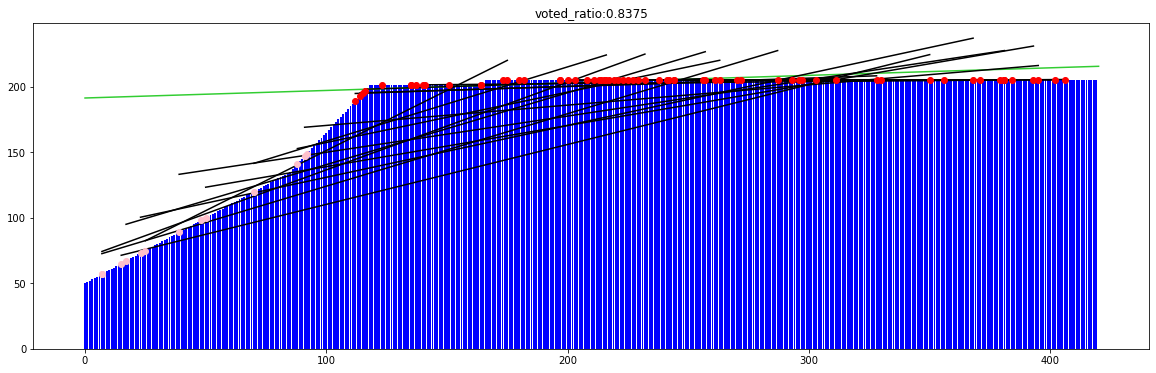

In [50]:
line_number = 20
point_number = 4

distance_th = 10

# unit_number の arrayを取得
unit_number_array = np.array(list(map(lambda state: state.unit_number, good_state_list)))
unit_number_tensor = torch.from_numpy(unit_number_array)


x = np.arange(0, len(unit_number_array))
x_tensor = torch.from_numpy(x).float()

# line_number の数だけサンプリング(重複なし)
random_index = np.array([np.random.permutation(len(unit_number_array))[:point_number] for i in range(line_number)])  # 重複なく(.line_number, point_number)のインデックスを取得

sampled_unit_number_tensor = torch.from_numpy(unit_number_array[random_index]).float()  # (line_number(m), point_number(s))
sampled_x_tensor = torch.from_numpy(x[random_index]).float()  # (line_number(m), point_number(s))

sampled_unit_number_tensor_flatten = sampled_unit_number_tensor.flatten()  # (m*n)ベクトルとして利用する場合
sampled_x_tensor_flatten  = sampled_x_tensor.flatten()  # (m*n)ベクトルとして利用する場合


# バッチの最小二乗解
b_X = torch.stack([sampled_x_tensor, torch.ones_like(sampled_x_tensor).float()],dim=2)
b_XtX = torch.bmm(b_X.transpose(1,2),b_X)
b_inv_XtX = torch.inverse(b_XtX)
b_Xty = torch.bmm(b_X.transpose(1,2), sampled_unit_number_tensor[:,:,None])

b_beta_hat = torch.bmm(b_inv_XtX, b_Xty)  # (line_number(m),2,1) であることに注意

b_beta_hat_squeeze = b_beta_hat.squeeze()  # (line_number(m),2)
        
# 距離の計算
a = b_beta_hat_squeeze[:,0]  # (line_number(m))
c = b_beta_hat_squeeze[:,1]  # (line_number(m))
d_num = a[:,None] * sampled_x_tensor_flatten[None,:]  - sampled_unit_number_tensor_flatten[None,:] + c[:,None]  # (line_number(m), all_point_number(n))
d_den = torch.sqrt(a**2+(-1)**2)  # (line_number(m))
d = torch.abs(d_num) / d_den[:,None]
print("d mean:",d.mean())

distance_boolean = d < distance_th  # (line_number(m), all_point_number(n))

b_vote_number = distance_boolean.sum(dim=1)  # (line_number(m))
vote_max = np.amax(b_vote_number.numpy(), axis=0)  # 必要なのは最大投票数

print("voted_ratio:",vote_max/(line_number*point_number))
ransac_solution_index = np.argmax(b_vote_number.numpy(),axis=0)  # 正確な比較のためにnumpyで計算
ransac_solution_voted_points_bool = distance_boolean[ransac_solution_index].numpy()  # 距離の閾値を満たす点のブール 

ransac_solution = b_beta_hat_squeeze[ransac_solution_index].numpy()

# visualize_unit_number_bokeh("voted_ratio:{}".format(vote_max/(line_number*point_number)),
#                             x,
#                             unit_number_array,
#                             ransac_solution,
#                             sampled_x_tensor,
#                             b_beta_hat,
#                             sampled_x_tensor_flatten,
#                             sampled_unit_number_tensor_flatten,
#                             ransac_solution_voted_points_bool
#                            )
visualize_unit_number_matplotlib("voted_ratio:{}".format(vote_max/(line_number*point_number)),
                                 x,
                                 unit_number_array,
                                 ransac_solution,
                                 sampled_x_tensor,
                                 b_beta_hat,
                                 sampled_x_tensor_flatten,
                                 sampled_unit_number_tensor_flatten,
                                 ransac_solution_voted_points_bool
                                )

In [34]:
line_number = 20
point_number = 4

distance_th = 10

# unit_number の arrayを取得
unit_number_array = np.array(list(map(lambda state: state.unit_number, bad_state_list)))
unit_number_tensor = torch.from_numpy(unit_number_array)


x = np.arange(0, len(unit_number_array))
x_tensor = torch.from_numpy(x).float()

# line_number の数だけサンプリング(重複なし)
random_index = np.array([np.random.permutation(len(unit_number_array))[:point_number] for i in range(line_number)])  # 重複なく(.line_number, point_number)のインデックスを取得

sampled_unit_number_tensor = torch.from_numpy(unit_number_array[random_index]).float()  # (line_number(m), point_number(s))
sampled_x_tensor = torch.from_numpy(x[random_index]).float()  # (line_number(m), point_number(s))

sampled_unit_number_tensor_flatten = sampled_unit_number_tensor.flatten()  # (m*n)ベクトルとして利用する場合
sampled_x_tensor_flatten  = sampled_x_tensor.flatten()  # (m*n)ベクトルとして利用する場合


# バッチの最小二乗解
b_X = torch.stack([sampled_x_tensor, torch.ones_like(sampled_x_tensor).float()],dim=2)
b_XtX = torch.bmm(b_X.transpose(1,2),b_X)
b_inv_XtX = torch.inverse(b_XtX)
b_Xty = torch.bmm(b_X.transpose(1,2), sampled_unit_number_tensor[:,:,None])

b_beta_hat = torch.bmm(b_inv_XtX, b_Xty)  # (line_number(m),2,1) であることに注意

b_beta_hat_squeeze = b_beta_hat.squeeze()  # (line_number(m),2)
        
# 距離の計算
a = b_beta_hat_squeeze[:,0]  # (line_number(m))
c = b_beta_hat_squeeze[:,1]  # (line_number(m))
d_num = a[:,None] * sampled_x_tensor_flatten[None,:]  - sampled_unit_number_tensor_flatten[None,:] + c[:,None]  # (line_number(m), all_point_number(n))
d_den = torch.sqrt(a**2+(-1)**2)  # (line_number(m))
d = torch.abs(d_num) / d_den[:,None]
print("d mean:",d.mean())

distance_boolean = d < distance_th  # (line_number(m), all_point_number(n))

b_vote_number = distance_boolean.sum(dim=1)  # (line_number(m))
vote_max = np.amax(b_vote_number.numpy(), axis=0)  # 必要なのは最大投票数

print("voted_ratio:",vote_max/(line_number*point_number))
ransac_solution_index = np.argmax(b_vote_number.numpy(),axis=0)  # 正確な比較のためにnumpyで計算
ransac_solution_voted_points_bool = distance_boolean[ransac_solution_index].numpy()  # 距離の閾値を満たす点のブール 

ransac_solution = b_beta_hat_squeeze[ransac_solution_index].numpy()

visualize_unit_number("voted_ratio:{}".format(vote_max/(line_number*point_number)),
                      x,
                      unit_number_array,
                      ransac_solution,
                      sampled_x_tensor,
                      b_beta_hat,
                      sampled_x_tensor_flatten,
                      sampled_unit_number_tensor_flatten,
                      ransac_solution_voted_points_bool
                     )

d mean: tensor(29.9924)
voted_ratio: 0.7625


In [72]:
class RansacGradLearningDecider():
    def __init__(self, line_number=10, point_number=2, distance_th=0.2, decision_rate=0.7, grad_abs_limit=20):
        self.line_number = line_number
        self.point_number = point_number
        self.distance_th = distance_th
        self.decision_rate = decision_rate
        self.grad_abs_limit = grad_abs_limit
        self.save_path = None
        
    def set_save_path(self, save_path):
        self.save_path = save_path
        
    def decide(self, state_list, info_list, env):
        """
        うまく学習できているかどうか判定
        """
        # unit_number の arrayを取得
        unit_number_array = np.array(list(map(lambda state: state.unit_number, bad_state_list)))
        unit_number_tensor = torch.from_numpy(unit_number_array)


        x = np.arange(0, len(unit_number_array))
        x_tensor = torch.from_numpy(x).float()

        # line_number の数だけサンプリング(重複なし)
        random_index = np.array([np.random.permutation(len(unit_number_array))[:self.point_number] for i in range(self.line_number)])  # 重複なく(.line_number, point_number)のインデックスを取得

        sampled_unit_number_tensor = torch.from_numpy(unit_number_array[random_index]).float()  # (line_number(m), point_number(s))
        sampled_x_tensor = torch.from_numpy(x[random_index]).float()  # (line_number(m), point_number(s))

        sampled_unit_number_tensor_flatten = sampled_unit_number_tensor.flatten()  # (m*n)ベクトルとして利用する場合
        sampled_x_tensor_flatten  = sampled_x_tensor.flatten()  # (m*n)ベクトルとして利用する場合


        # バッチの最小二乗解
        b_X = torch.stack([sampled_x_tensor, torch.ones_like(sampled_x_tensor).float()],dim=2)
        b_XtX = torch.bmm(b_X.transpose(1,2),b_X)
        b_inv_XtX = torch.inverse(b_XtX)
        b_Xty = torch.bmm(b_X.transpose(1,2), sampled_unit_number_tensor[:,:,None])

        b_beta_hat = torch.bmm(b_inv_XtX, b_Xty)  # (line_number(m),2,1) であることに注意

        b_beta_hat_squeeze = b_beta_hat.squeeze()  # (line_number(m),2)

        # 距離の計算
        a = b_beta_hat_squeeze[:,0]  # (line_number(m))
        c = b_beta_hat_squeeze[:,1]  # (line_number(m))
        d_num = a[:,None] * sampled_x_tensor_flatten[None,:]  - sampled_unit_number_tensor_flatten[None,:] + c[:,None]  # (line_number(m), all_point_number(n))
        d_den = torch.sqrt(a**2+(-1)**2)  # (line_number(m))
        d = torch.abs(d_num) / d_den[:,None]

        distance_boolean = d < distance_th  # (line_number(m), all_point_number(n))

        b_vote_number = distance_boolean.sum(dim=1)  # (line_number(m))
        vote_max = np.amax(b_vote_number.numpy(), axis=0)  # 必要なのは最大投票数

        ransac_solution_index = np.argmax(b_vote_number.numpy(),axis=0)  # 正確な比較のためにnumpyで計算
        ransac_solution_voted_points_bool = distance_boolean[ransac_solution_index].numpy()  # 距離の閾値を満たす点のブール 

        ransac_solution = b_beta_hat_squeeze[ransac_solution_index].numpy()
        # 最大投票数の割合によって判定
        if vote_max / (self.line_number * self.point_number) < self.decision_rate:  # 近い割合がdecision_rateより低い場合
            if abs(beta_hat[0]) < self.grad_abs_limit:  # 傾きが大きすぎない
                return_bool = True
            else:
                return_bool = False
        else:
            return_bool = False
            
        if self.save_path is not None:
            visualize_unit_number_matplotlib("voted_ratio:{}".format(vote_max/(line_number*point_number)),
                                             x,
                                             unit_number_array,
                                             ransac_solution,
                                             sampled_x_tensor,
                                             b_beta_hat,
                                             sampled_x_tensor_flatten,
                                             sampled_unit_number_tensor_flatten,
                                             ransac_solution_voted_points_bool,
                                             save_path=self.save_path
                                            )
        
        return return_bool

In [76]:
lr_eval_decider = RansacGradLearningDecider(line_number=20, point_number=4, distance_th=5, decision_rate=0.1)

In [77]:
from pathlib import Path
save_path = Path("visualize_unit_nuber.png")
lr_eval_decider.save_path = save_path

In [78]:
lr_eval_decider.decide(good_state_list, good_info_list, env)

False

In [79]:
lr_eval_decider.decide(bad_state_list, bad_info_list, env)

False